# In this notebook, we will attempt to model market movements and make predictions one day out using stochastic processes which are mean reverting and contain drift compoenents

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import yfinance as yf

In [2]:
sp = yf.Ticker('SPY')
sp_df = sp.history(period='max')
sp_df.head()

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
1993-01-29,26.32,26.32,26.19,26.30,1003200,0.0,0
1993-02-01,26.32,26.49,26.32,26.49,480500,0.0,0
1993-02-02,26.47,26.56,26.41,26.54,201300,0.0,0
1993-02-03,26.58,26.84,26.56,26.82,529400,0.0,0
1993-02-04,26.92,26.99,26.62,26.94,531500,0.0,0


## We start first with a simple model: the price on day t is given by the price on the previous day plus some return. More specifically,

$p_t = p_{t-1} + \epsilon_{t-1}$, where $\epsilon_{t-1}$ is drawn from the distribution of returns.

In [3]:
sp_df = sp_df.drop(columns=['Dividends', 'Stock Splits'])
sp_df['day_change'] = sp_df.Close - sp_df.Open
sp_df.head()

,Open,High,Low,Close,Volume,day_change
Date,,,,,,
1993-01-29,26.32,26.32,26.19,26.30,1003200,-0.02
1993-02-01,26.32,26.49,26.32,26.49,480500,0.17
1993-02-02,26.47,26.56,26.41,26.54,201300,0.07
1993-02-03,26.58,26.84,26.56,26.82,529400,0.24
1993-02-04,26.92,26.99,26.62,26.94,531500,0.02


### Question: should we be looking at change from close on day i to day i+1 ???

### I think it depends on your goal. Are you trying to predict next day close from prior day close or current day close from open?

If the latter, then using day change makes the most sense I think, but if the former, then I think we may want to use gain from one day to next rather than the gain from open.

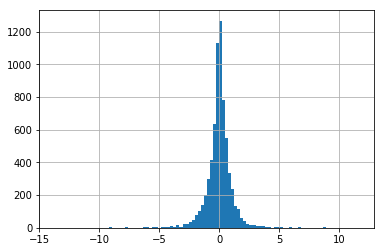

In [4]:
sp_df.day_change.hist(bins=100)
plt.show()

### Question: do we need to normalize the returns above? The distribution has a very sharp peak...

In [5]:
returns = sp_df.day_change.values
returns

array([-0.02,  0.17,  0.07, ..., -9.08,  6.07,  0.62])

In [6]:
close_vals = sp_df.Close.values
close_vals

array([ 26.3 ,  26.49,  26.54, ..., 265.13, 274.03, 278.2 ])

In [7]:
close_preds = [] 
for close in close_vals:
    close_pred = close + np.random.choice(returns, size=1, replace=False)
    close_preds.append(close_pred)

In [8]:
rmse = np.sqrt(np.sum((close_preds - close_vals)**2)/len(close_preds))
rmse

8197.43757478712

C:\Users\jfm62\Anaconda3\lib\site-packages\pandas\plotting\_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


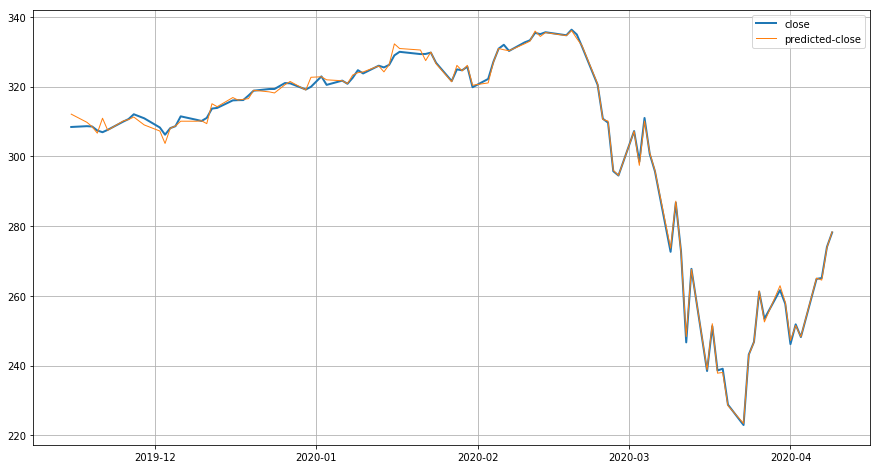

In [9]:
fig,ax = plt.subplots(figsize=(15,8))
x = sp_df.index.values
plt.plot(x[-100:], close_vals[-100:], label='close', linewidth=2.0)
plt.plot(x[-100:], close_preds[-100:], label='predicted-close', linewidth=1.0,)
plt.grid()
plt.legend()
plt.show()

In [10]:
def naive_model(sp_df):
    """
    Model market movements by sampling from distribution of S&P500 returns
    
    Goal: given current day close, predict next day close
    
    p_t = p_{t-1} + epsilon,
    
    where epsilon is randomly chosen
    """
    # the daily return
    try:
        returns = sp_df['day_change']
    except:
        returns = sp_df.Close.values - sp_df.Open.values
    
    close_vals = sp_df.Close.values
    
    sp_df['close_pred'] = sp_df.loc[:, 'Close'].shift(periods=1) + np.random.choice(returns, size=len(sp_df),
                                                                                replace=False)
    close_preds = sp_df.close_pred.values   
    
    ## model evaluation
    rmse = np.sqrt(np.sum((close_preds[1:] - close_vals[1:])**2)/(len(close_preds)-1))

    return close_preds, rmse

In [11]:
close_preds, rmse = naive_model(sp_df)

In [12]:
rmse

1.9095495918387637

## Re-doing as I think I did it wrong:

In [13]:
sp_df['close_pred'] = sp_df.loc[:, 'Close'].shift(periods=1) + np.random.choice(returns, size=len(sp_df),
                                                                                replace=False)
sp_df.head()

,Open,High,Low,Close,Volume,day_change,close_pred
Date,,,,,,,
1993-01-29,26.32,26.32,26.19,26.30,1003200,-0.02,NaN
1993-02-01,26.32,26.49,26.32,26.49,480500,0.17,26.49
1993-02-02,26.47,26.56,26.41,26.54,201300,0.07,25.88
1993-02-03,26.58,26.84,26.56,26.82,529400,0.24,26.15
1993-02-04,26.92,26.99,26.62,26.94,531500,0.02,27.27


In [14]:
sp_df.tail(10)

,Open,High,Low,Close,Volume,day_change,close_pred
Date,,,,,,,
2020-03-27,253.27,260.81,251.05,253.42,224341200,0.15,261.43
2020-03-30,255.70,262.43,253.53,261.65,171369500,5.95,252.60
2020-03-31,260.56,263.33,256.22,257.75,194881100,-2.81,262.16
2020-04-01,247.98,257.66,243.90,246.15,189554600,-1.83,256.06
2020-04-02,245.19,252.68,244.59,251.83,177660400,6.64,246.02
2020-04-03,250.76,253.32,245.22,248.19,135561200,-2.57,250.17
2020-04-06,257.84,267.00,248.17,264.86,188061200,7.02,244.30
2020-04-07,274.21,275.03,264.89,265.13,201427200,-9.08,264.85
2020-04-08,267.96,276.00,265.25,274.03,153774500,6.07,265.71


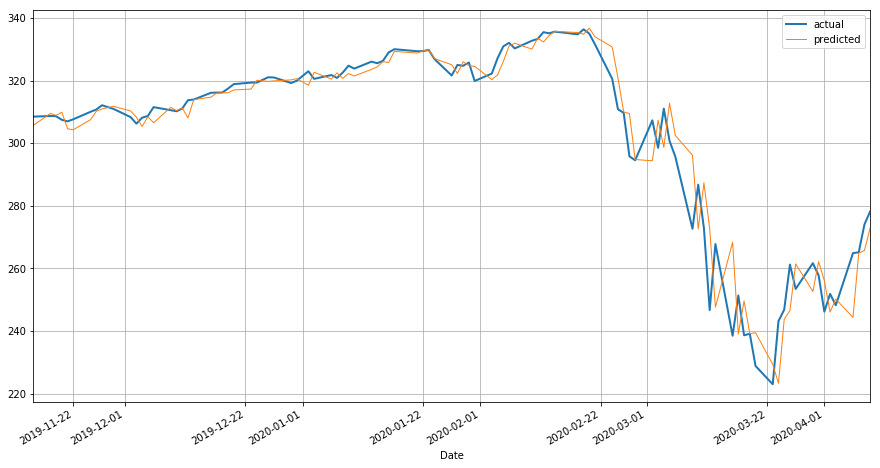

In [15]:
fig,ax = plt.subplots(figsize=(15,8))
sp_df.Close[-100:].plot(label='actual', linewidth=2.0)
sp_df.close_pred[-100:].plot(label='predicted', linewidth=1.0)
plt.grid()
plt.legend()
plt.show()

## This is less good. You were doing it wrong before. You were taking taking the current day's close and adding a random sample from the distribution of returns. So your predictions were very close because you were already using the ground truth in some sense, but adding to it

In [16]:
rmse = np.sqrt(np.sum((sp_df.close_pred.values[1:] - sp_df.Close.values[1:])**2)/(len(sp_df)-1))
rmse

1.9165578515264454

# For our 'simple' model we essentially want to make predictions on a sliding window of 30 days. We will use the returns from the last 30 days to be our distribution of returns from which we will take a random sample to add to the current day's closing price, in order to obtain a prediction for the following day's closing price

In [17]:
sp_df[30:60]

,Open,High,Low,Close,Volume,day_change,close_pred
Date,,,,,,,
1993-03-15,26.97,27.12,26.97,27.12,310800,0.15,27.34
1993-03-16,27.12,27.20,27.12,27.12,30800,0.00,26.38
1993-03-17,27.08,27.08,26.92,26.95,21800,-0.13,26.99
1993-03-18,27.07,27.23,27.07,27.12,59300,0.05,28.30
1993-03-19,27.23,27.23,27.08,27.08,66900,-0.15,25.58
1993-03-22,26.82,26.99,26.80,26.93,183400,0.11,28.11
1993-03-23,27.01,27.02,26.95,26.99,55200,-0.02,27.33
1993-03-24,26.95,27.10,26.82,26.99,37200,0.04,28.20
1993-03-25,27.01,27.21,26.97,27.16,110100,0.15,26.22


In [18]:
sp_df.head()

,Open,High,Low,Close,Volume,day_change,close_pred
Date,,,,,,,
1993-01-29,26.32,26.32,26.19,26.30,1003200,-0.02,NaN
1993-02-01,26.32,26.49,26.32,26.49,480500,0.17,26.49
1993-02-02,26.47,26.56,26.41,26.54,201300,0.07,25.88
1993-02-03,26.58,26.84,26.56,26.82,529400,0.24,26.15
1993-02-04,26.92,26.99,26.62,26.94,531500,0.02,27.27


In [19]:
len(sp_df)

6849

In [20]:
def get_windows(df, window=30):
    return_windows = []
    pred_windows = []
    for i in range(len(df)-window):
        return_window = df[i:i+window]
        pred_window = df[i+window:i+(2*window)]

        return_windows.append(return_window)
        pred_windows.append(pred_window)
        
    return return_windows, pred_windows

return_windows, pred_windows = get_windows(sp_df)

In [21]:
print(len(return_windows), len(pred_windows))

6819 6819


In [22]:
return_windows[0]

,Open,High,Low,Close,Volume,day_change,close_pred
Date,,,,,,,
1993-01-29,26.32,26.32,26.19,26.30,1003200,-0.02,NaN
1993-02-01,26.32,26.49,26.32,26.49,480500,0.17,26.49
1993-02-02,26.47,26.56,26.41,26.54,201300,0.07,25.88
1993-02-03,26.58,26.84,26.56,26.82,529400,0.24,26.15
1993-02-04,26.92,26.99,26.62,26.94,531500,0.02,27.27
1993-02-05,26.92,26.97,26.77,26.92,492100,0.00,26.63
1993-02-08,26.92,27.01,26.88,26.92,596100,0.00,25.20
1993-02-09,26.82,26.82,26.67,26.73,122100,-0.09,27.51
1993-02-10,26.73,26.79,26.65,26.77,379600,0.04,27.62


In [23]:
pred_windows[1]

,Open,High,Low,Close,Volume,day_change,close_pred
Date,,,,,,,
1993-03-16,27.12,27.20,27.12,27.12,30800,0.00,26.38
1993-03-17,27.08,27.08,26.92,26.95,21800,-0.13,26.99
1993-03-18,27.07,27.23,27.07,27.12,59300,0.05,28.30
1993-03-19,27.23,27.23,27.08,27.08,66900,-0.15,25.58
1993-03-22,26.82,26.99,26.80,26.93,183400,0.11,28.11
1993-03-23,27.01,27.02,26.95,26.99,55200,-0.02,27.33
1993-03-24,26.95,27.10,26.82,26.99,37200,0.04,28.20
1993-03-25,27.01,27.21,26.97,27.16,110100,0.15,26.22
1993-03-26,27.14,27.16,26.99,27.01,101500,-0.13,28.17


In [24]:
def simple_model(sp_df):
    """
    Model market movements by sampling from distribution of S&P500 returns over a 30-day window
    
    Goal: given current day close, predict next day close
    
    p_t = p_{t-1} + epsilon,
    
    where epsilon is randomly chosen from returns over the last 30 days
    """
    close_vals = sp_df.Close.values
    close_preds = []
    
    windows = get_windows(sp_df, window=30)
    for window in windows:
        window_returns = window.day_change.values
        
        window_preds = naive_model(window, error=False)
        
        #print(window_preds)
        close_preds.append(window_preds)
        break
        
    #print(len(close_preds))
    #close_preds = np.reshape(close_preds, (len(close_vals),1))
    
    ## model evaluation
    #rmse = np.sqrt(np.sum((close_preds - close_vals)**2)/len(close_preds))
    
    return close_preds, rmse

In [25]:
windowed_preds, windowed_rmse = simple_model(sp_df)

AttributeError: 'list' object has no attribute 'day_change'

In [ ]:
windowed_rmse

# Ornstein-Uhlenbeck model, Vasieck Model, Stochastic Volatility Models

In [ ]:
# Implement Euler Maruyama Scheme
def euler_maruyama():
    """
    approximates the solution of a stochastic differential equation
    consider
    
    dX_t = a(X_t)dt + b(X_t)dW_t
    X_0 = x_0
    
    we wish to solve this SDE on interval [0,T]
    
    The EM approximation to the true solution X is the Markov Chain
    defined as:
    
    (1) partition the interval [0,T] into N equal subintervals of
    width dt > 0 ;
        0 = t_0 < ... < t_N = T, dt = T/N
    (2) set Y_0 = x_0
    (3) recursively define Y_n for n in [1,N] by:
        Y_n+1 = Y_n + a(Y_n)dt + b(Y_n)dW_n,
        
        where dW_n = W_{t_n+1} - W_{t_n}
        
    The random variables ΔWn are independent and identically distributed 
    normal random variables with expected value zero and variance Δt. 
    """
    
    return